## 8.7 다층 퍼셉트론(MLP)으로 텍스트 분류하기
이번에는 영문 뉴스 그룹의 토픽을 분류하는 예제를 자연어 전처리부터 딥러닝까지 한번에 실습하는 예제를 수행해보자.

### 8.7.1 다층 퍼셉트론(MultiLayer Perceptron, MLP)
hidden layer가 하나 이상 존재하는 신경망이다.

### 8.7.2 keras의 texts_to_matrix()
MLP로 텍스트 분류를 수행하기 전에 이번에 사용할 도구인 케라스 Tokenizer의 texts_to_matrix()를 이해해봅시다.

먼저 Tokenizer로 학습데이터를 학습하여, 학습된 단어사전을 살펴보자.

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']
t = Tokenizer()
t.fit_on_texts(texts)
print(t.word_index)
print(t.index_word)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}
{1: '바나나', 2: '먹고', 3: '싶은', 4: '사과', 5: '길고', 6: '노란', 7: '저는', 8: '과일이', 9: '좋아요'}


각 단어에 숫자 1부터 시작하는 정수 인덱스가 Corpus에서 노출된 빈도 순에 따라 부여되었다. 

이제 텍스트 데이터에 texts_to_matrix()를 사용하면, DTM를 생성해준다.

In [20]:
print(t.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


t.texts_to_matrix 메소드의 mode 옵션은 다음과 같은 4개의 값을 입력할 수 있다.
- "binary" : 각 doc에서 단어의 출현여부 만을 0, 1로 표시한 DTM를 생성. 기본값
- "count" : 단어의 출현 빈도를 표시한 DTM 생성.
- "tfidf" : 단어의 TF-IDF를 표시한 DTM 생성.
- "freq" : 각 doc에서 단어의 출현 비율을 표시한 DTM 생성.

In [21]:
print(t.texts_to_matrix(texts, mode = 'binary'))
print(t.texts_to_matrix(texts, mode = 'tfidf').round(2))
print(t.texts_to_matrix(texts, mode = 'freq').round(2))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]
[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


### 8.7.3 20개 뉴스 그룹(Twenty Newsgroups) 데이터
사이킷런에서는 20개의 다른 주제를 가진 18,846개의 뉴스 그룹 이메일 데이터를 제공합니다.

훈련 샘플은 11,314개가 존재합니다. target_names에는 20개의 주제의 이름을 담고있습니다. 

In [22]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.
print(newsdata.keys())
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
훈련용 샘플의 개수 : 11314
총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [23]:
print(newsdata.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

이번 챕터 실습의 목적은 테스트 데이터에서 이메일 본문을 보고 20개의 주제 중 어떤 주제인지를 맞추는 것입니다. 레이블인 target에는 총 0부터 19까지의 숫자가 들어가있다.

In [24]:
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))
print('7번 레이블이 의미하는 주제 : {}'.format(newsdata.target_names[7]))
print(newsdata.data[0])

첫번째 샘플의 레이블 : 7
7번 레이블이 의미하는 주제 : rec.autos
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [29]:
print(newsdata.data[1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



이메일의 내용을 보니 스포츠 카에 대한 글로 보입니다. 이 글의 레이블은 7이고, 7번 레이블은 rec.autos란 주제를 의미합니다. 이제 훈련에 사용될 메일 본문인 data와 레이블인 target을 데이터프레임으로 만들어서 데이터에 대한 통계적인 정보들을 알아보겠습니다.

In [25]:
data = pd.DataFrame(newsdata.data, columns = ['email']) # data로부터 데이터프레임 생성
data['target'] = pd.Series(newsdata.target) # target 열 추가
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


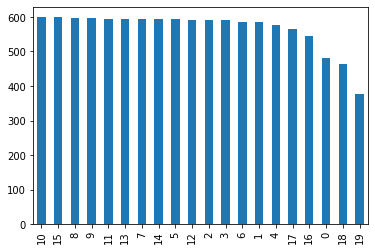

In [27]:
data['target'].value_counts().plot(kind='bar')

이제 데이터프레임으로부터 다시 메일 본문과 레이블을 분리하고, 테스트 데이터 또한 불러오겠습니다.

In [28]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True) # 'test'를 기재하면 테스트 데이터만 리턴한다.
train_email = data['email'] # 훈련 데이터의 본문 저장
train_label = data['target'] # 훈련 데이터의 레이블 저장
test_email = newsdata_test.data # 테스트 데이터의 본문 저장
test_label = newsdata_test.target # 테스트 데이터의 레이블 저장

훈련 데이터와 테스트 데이터가 모두 준비되었습니다. 케라스의 토크나이저 도구를 사용하여 전처리를 진행해봅시다.

In [31]:
max_words = 10000 # 실습에 사용할 단어의 최대 개수
num_classes = 20 # 레이블의 수

전처리 함수를 아래와 같이 정의합니다.

In [32]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    t = Tokenizer(num_words = max_words) # max_words 개수만큼의 단어만 사용한다.
    t.fit_on_texts(train_data)
    X_train = t.texts_to_matrix(train_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    X_test = t.texts_to_matrix(test_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    return X_train, X_test, t.index_word

'binary' 모드를 사용하여 전처리 작업이 잘 수행되었는 지 확인해봅니다.

In [33]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


X_train은 전체 학습 메일에서 빈도수가 높은 1만개의 word에 대해 각, 메일에서의 출현여부를 저장하는 DTM이다.

In [35]:
doc0idx = np.where(X_train[0] == 1)[0]
doc0idx

array([   1,    2,    3,    4,    7,    8,    9,   11,   13,   14,   15,
         16,   17,   18,   21,   25,   26,   27,   29,   32,   34,   35,
         36,   38,   39,   42,   44,   47,   58,   63,   66,   77,   78,
         80,   86,   88,   91,   95,  112,  123,  153,  171,  181,  182,
        188,  198,  206,  211,  239,  250,  263,  273,  298,  337,  357,
        384,  484,  610,  628,  708,  726,  808,  816,  828,  843,  844,
       1078, 1162, 1308, 1341, 1347, 1350, 1376, 1497, 1498, 1767, 1835,
       2266, 2804, 2908, 2952, 4017, 4308, 7860, 8164, 9879], dtype=int64)

In [38]:
doc0words = []
for idx in doc0idx:
    doc0words.append(index_to_word[idx])

print(doc0words)

['the', 'to', 'of', 'a', 'in', 'i', 'is', 'it', 'you', 'from', 'edu', 'on', 'this', 'be', 'have', 'or', 'was', 'if', 'subject', 'lines', 'organization', 'by', '2', 'my', 'can', 'what', 'all', 'there', 'your', 'me', 'out', 'university', 'posting', 'were', 'other', 'know', 'host', 'nntp', 'e', 'could', 'where', 'anyone', 'please', 'really', 'mail', 'years', 'thanks', '15', 'made', 'thing', 'day', 'name', 'car', 'called', 'info', 'looking', 'small', 'college', 'history', 'saw', 'body', 'whatever', 'rest', 'model', 'early', 'front', 'engine', 'looked', 'wondering', 'brought', 'late', 'umd', 'addition', 'door', 'il', 'park', 'separate', 'sports', 'production', 'specs', 'maryland', 'doors', 'wam', 'neighborhood', 'bumper', 'enlighten']


In [39]:
print(train_email[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







num_words 옵션 값을 10000으로 지정하여, 이에 따른 shape을 얻었다. 이때 색인 0은 사용하지 않으므로, 실질적 상위 빈도수 9999개의 단어 행렬을 이룬다.

In [41]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))
try:
    print('사전에 없는 0번 단어 : {}'.format(index_to_word[0]))
except Exception as e:
    print(e)

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic
0


불용어에 해당되는 단어 'the'가 빈도수 상위 1번 단어가 된 것을 확인할 수 있습니다.

### 8.7.4 MLP를 이용한 텍스트 분류
[Quiz] 3개의 Dense layer와 중간 Dropout 레이어를 이용하여 adam 옵티마이저로 학습하고, test 데이터로 평가하는 fit_and_evaluate 함수를 작성한다.
- 첫 2개의 Dense layer의 유닛수는 각각 256, 128로 설정한다.
- 이때, 학습데이터의 10%를 평가용으로 split한다.
- 학습이 종료된 후, test 데이터로 평가한 후, 평가결과를 리턴한다.

prepare_data 함수와 fit_and_evaluate 함수를 이용하여 4가지 모드별로 평가를 진행하여, 어떤 모드가 더 성능이 좋은 지 알아보자.

In [49]:
def fit_and_evaluate(trainset, testset):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    
    model = Sequential()
    model.add(Dense(256, input_shape=(max_words,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(*trainset, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(*testset, batch_size=128, verbose=0)
    return score, model

In [82]:
scores = {}
models = {}
preds = {}
for mode in ['binary', 'count', 'tfidf', 'freq']:
    X_train, X_test, _ = prepare_data(train_email, test_email, mode)
    scores[mode], models[mode] = fit_and_evaluate((X_train, y_train), (X_test, y_test))
    preds[mode] = models[mode].predict(X_test)
    print(mode+' 모드의 테스트 손실/정확도:', scores[mode])

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 7s 693us/step - loss: 2.3012 - acc: 0.3311 - val_loss: 0.9869 - val_acc: 0.8083
Epoch 2/5
10182/10182 [==============================] - 4s 397us/step - loss: 0.8616 - acc: 0.7641 - val_loss: 0.4625 - val_acc: 0.8860
Epoch 3/5
10182/10182 [==============================] - 3s 286us/step - loss: 0.4387 - acc: 0.8802 - val_loss: 0.3470 - val_acc: 0.8966
Epoch 4/5
10182/10182 [==============================] - 5s 457us/step - loss: 0.2488 - acc: 0.9371 - val_loss: 0.2991 - val_acc: 0.9134
Epoch 5/5
10182/10182 [==============================] - 3s 253us/step - loss: 0.1687 - acc: 0.9602 - val_loss: 0.2847 - val_acc: 0.9178
binary 모드의 테스트 손실/정확도: [0.6393319352218843, 0.8267392460741518]
Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 6s 582us/step - loss: 2.5542 - acc: 0.2870 - val_loss: 1.4077 - val_acc: 0.7553
Epoch 2/5
10182/

In [83]:
scores

{'binary': [0.6393319352218843, 0.8267392460741518],
 'count': [0.7106900347463007, 0.8215613381633465],
 'tfidf': [0.7021080272285088, 0.8327137548684187],
 'freq': [1.3000228505658775, 0.6942379185005002]}

성능이 좋지 않았던, freq 모델만 제외하고, 앙상블을 하여 최종 성능을 측정하면, 다음과 같은 결과를 얻을 수 있다.

In [84]:
sumprob = np.zeros((X_test.shape[0], num_classes))
for mode in ['binary', 'count', 'tfidf']:
    sumprob += preds[mode]
    
meanprob = sumprob / 3
ensemblePred = np.argmax(meanprob, axis=1)
ensemblePred

array([ 4,  1,  0, ...,  9, 12, 15], dtype=int64)

In [85]:
(test_label == ensemblePred).mean()

0.8454593733404142

일반적으로 서로 다른 로직의 모델을 경쟁시키는 앙상블 모델은 개별 모델들보다 항상 좋은 성능을 제공한다.